# Analyzing housing price of California and train a regression model to predict price.

Author: Xiaochen Li \
The original dataset appeared in R. Kelley Pace and Ronald Barry, “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–297.


In [15]:
%matplotlib notebook
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:

# Path and URLs
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

# Fetch Data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
            os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path)  
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close()
#fetch_housing_data()




In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# All attributes are numerical attributes type but ocean_proximity
housing['ocean_proximity'].value_counts()
# --> categorical attributes

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<IPython.core.display.Javascript object>


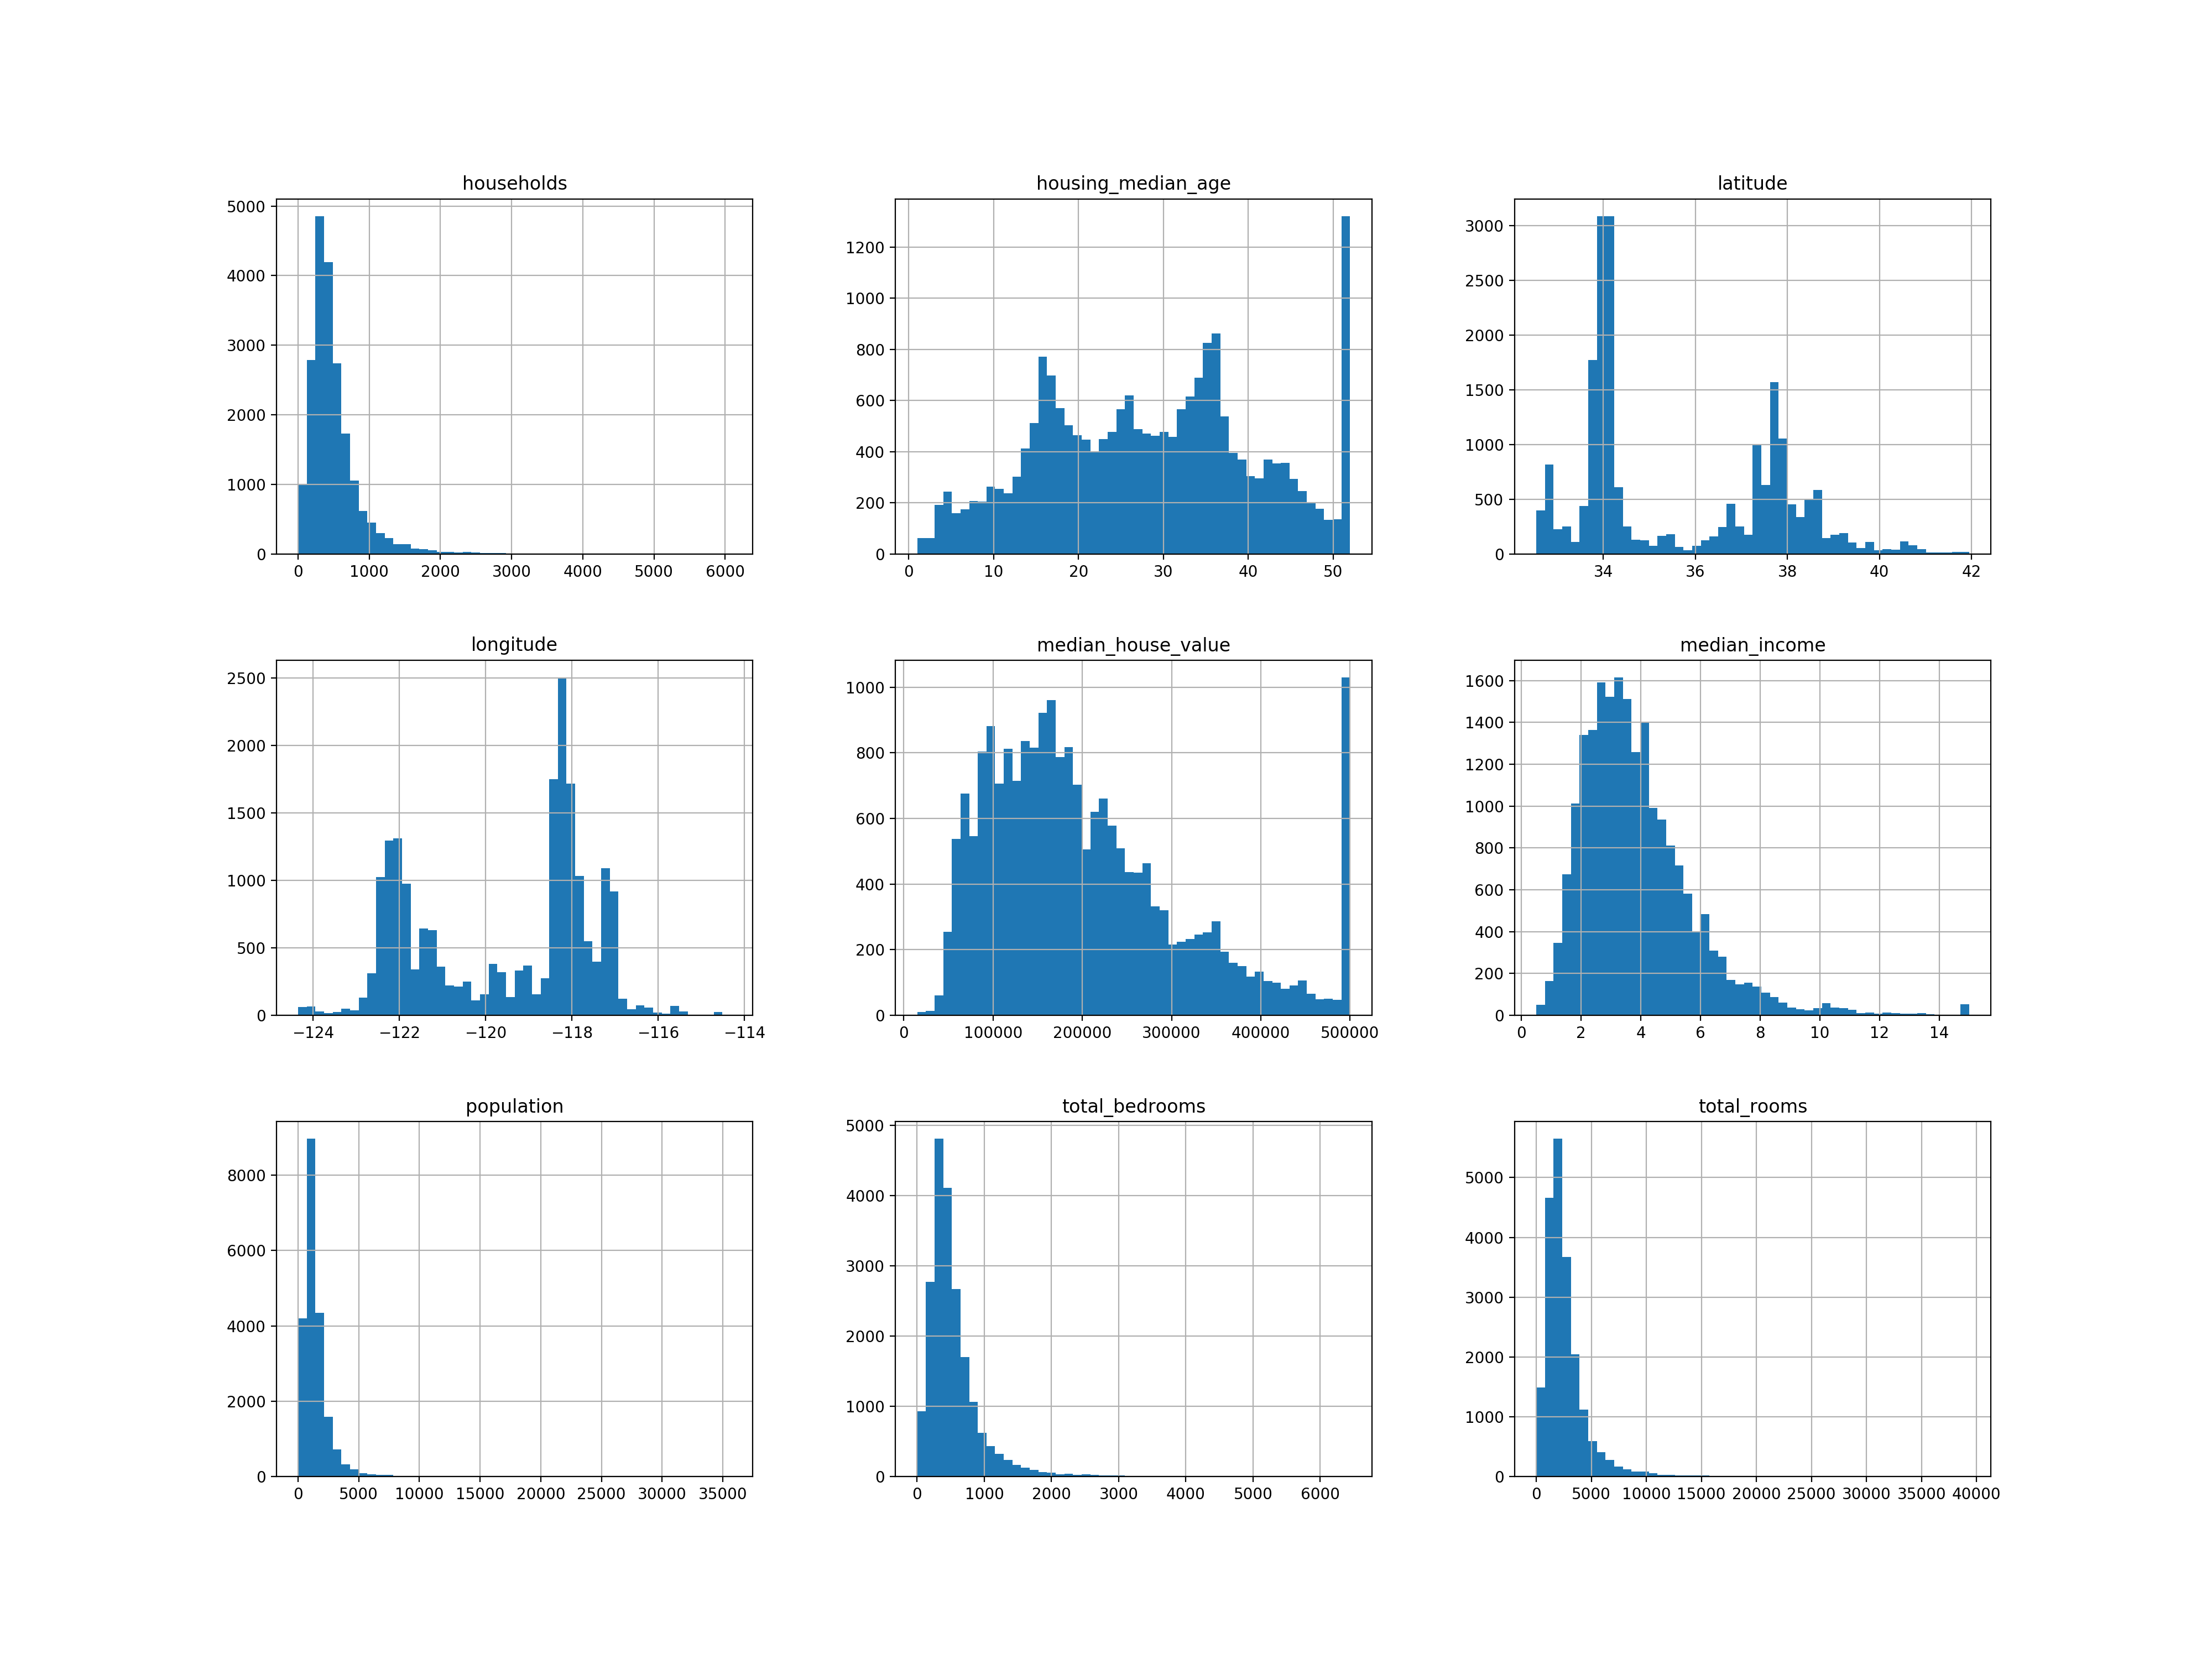

In [8]:
# Visualization of numerical cols
housing.hist(bins=50, figsize=(20,15))
plt.show()



## Raw Data Summary 
1. Some data are capped: housing_median_age and median_house_value, the later one can be a problem since it is my label
2. Households, Population, total_bedrooms, total_rooms are tail heavy, this may affect learning algorithm. Via EDA I will normalize them to more of a bell shape

In [9]:
# Stratified Sampling
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    print("TRAIN:", len(train_index), "TEST", len(test_index))
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

TRAIN: 16512 TEST 4128


## Visualization on the Stratifid Training Sets

In [11]:
housing = strat_train_set.copy()

<IPython.core.display.Javascript object>


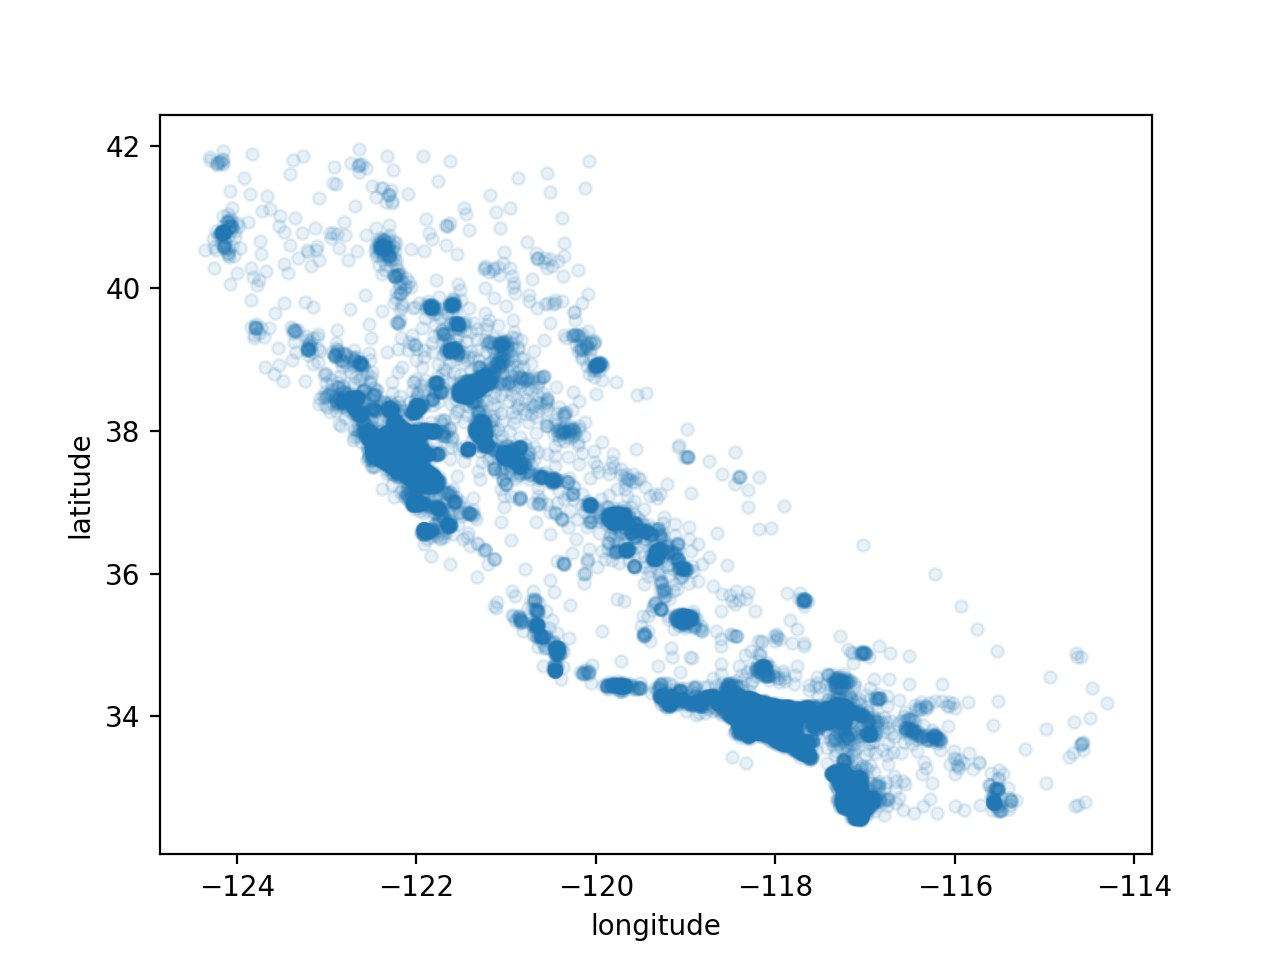

In [12]:
## Area Density

housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.1)
plt.show()

<IPython.core.display.Javascript object>


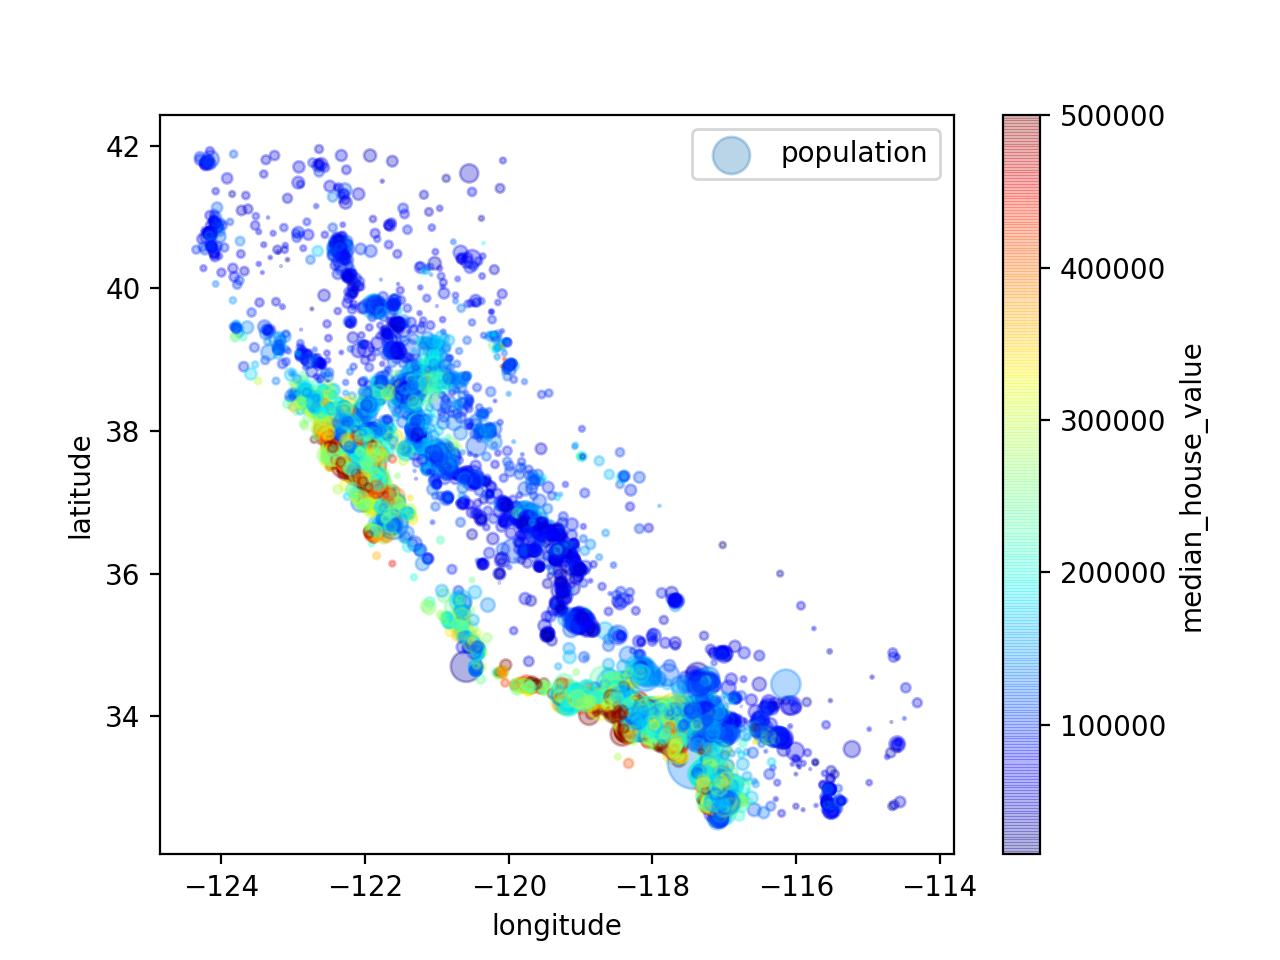

In [13]:
## size-population
## label-population
## color-prize
## color-map - jet
housing.plot(kind="scatter", x="longitude", y="latitude", 
             alpha=0.3, s=housing["population"] / 100, 
             label="population", c="median_house_value", 
             cmap=plt.get_cmap("jet"), colorbar=True
)
plt.show()

<IPython.core.display.Javascript object>


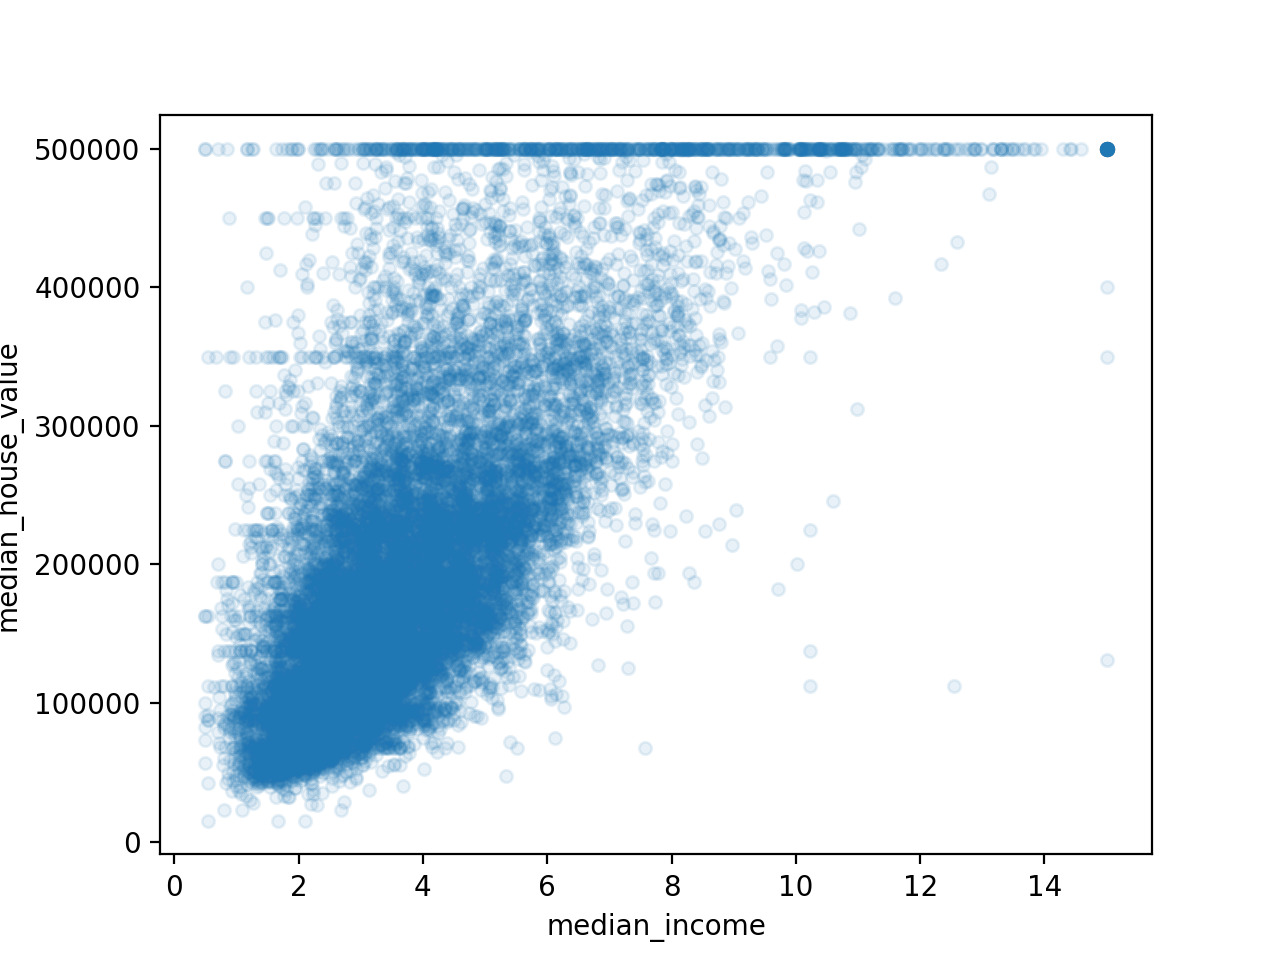

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## Summary from the corr graph
There are some data quirks 